# LPFormer: An Adaptive Graph Transformer for Link Prediction

This notebook implements the LPFormer model as described in the paper "LPFormer: An Adaptive Graph Transformer for Link Prediction" (Shomer et al., 2024), applied to the Marvel Universe dataset. The implementation includes all components described in the paper:

1. GCN-based node representation learning
2. PPR-based relative positional encodings with order invariance
3. GATv2 attention mechanism for adaptive pairwise encoding
4. Efficient node selection via PPR thresholding using Andersen's algorithm
5. Proper evaluation metrics as specified in the paper
6. LP factor analysis for performance evaluation

The implementation is optimized for GPU execution.

## 1. Setup and Dependencies

In [1]:
# Install core PyTorch (with CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric and dependencies for CUDA 11.8
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

# Install other required packages
!pip install numpy pandas scipy matplotlib networkx tqdm scikit-learn
!pip install ipywidgets --upgrade
!pip show ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Name: ipywidgets
Version: 8.1.7
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages
Requires: comm, ipython, jupyterlab_widgets, traitlets, widgetsnbextension
Required-by: jupyter


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.utils import to_undirected, add_self_loops, degree
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import scipy.sparse as sp
from scipy.sparse.linalg import norm as sparse_norm
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_cluster/_version_cud

Using device: cuda


## 2. Marvel Dataset Loading and Processing

We load and process the Marvel Universe dataset, which consists of connections between heroes and comics.

In [3]:
print("Loading Marvel dataset...")
start_time = time.time()

# Load the Marvel dataset
edges_df = pd.read_csv('edges_corr.csv')
nodes_df = pd.read_csv('nodes_corr.csv')

print(f"Dataset loaded in {time.time() - start_time:.2f} seconds")
print(f"Edges shape: {edges_df.shape}")
print(f"Nodes shape: {nodes_df.shape}")

# Display first few rows of each dataset
print("\nEdges preview:")
display(edges_df.head())

print("\nNodes preview:")
display(nodes_df.head())

# Check for missing values
print("\nMissing values in edges:", edges_df.isnull().sum().sum())
print("Missing values in nodes:", nodes_df.isnull().sum().sum())

# Summary statistics
print("\nUnique heroes:", edges_df['hero'].nunique())
print("Unique comics:", edges_df['comic'].nunique())
print("Node types:", nodes_df['type'].unique())
print("Node type counts:")
display(nodes_df['type'].value_counts())

Loading Marvel dataset...
Dataset loaded in 0.07 seconds
Edges shape: (96104, 2)
Nodes shape: (19090, 2)

Edges preview:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Nodes preview:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Missing values in edges: 0
Missing values in nodes: 0

Unique heroes: 6439
Unique comics: 12651
Node types: ['comic' 'hero']
Node type counts:


type
comic    12651
hero      6439
Name: count, dtype: int64

In [4]:
print("Processing Marvel dataset...")
start_time = time.time()

# Encode node IDs to indices
node_encoder = LabelEncoder()
nodes_df['node_idx'] = node_encoder.fit_transform(nodes_df['node'])

# Create a mapping from node names to indices
node_to_idx = {node: idx for node, idx in zip(nodes_df['node'], nodes_df['node_idx'])}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

# Map edges to node indices
edges_df['hero_idx'] = edges_df['hero'].map(node_to_idx)
edges_df['comic_idx'] = edges_df['comic'].map(node_to_idx)

# Check for mapping failures (NaN values)
missing_heroes = edges_df[edges_df['hero'].map(lambda x: x not in node_to_idx)]
missing_comics = edges_df[edges_df['comic'].map(lambda x: x not in node_to_idx)]

if len(missing_heroes) > 0 or len(missing_comics) > 0:
    print(f"Warning: Found {len(missing_heroes)} heroes and {len(missing_comics)} comics missing from nodes_df")
    # Filter out edges with missing nodes
    edges_df = edges_df[edges_df['hero'].map(lambda x: x in node_to_idx) &
                        edges_df['comic'].map(lambda x: x in node_to_idx)]
    # Recalculate indices
    edges_df['hero_idx'] = edges_df['hero'].map(node_to_idx)
    edges_df['comic_idx'] = edges_df['comic'].map(node_to_idx)

# Create edge index tensor
edge_index = torch.tensor([edges_df['hero_idx'].values.astype(np.int64),
                          edges_df['comic_idx'].values.astype(np.int64)], dtype=torch.long)

# Make the graph undirected for link prediction
edge_index = to_undirected(edge_index)

# Create node type encoding
nodes_df['type_idx'] = nodes_df['type'].map({'hero': 0, 'comic': 1})
node_types = torch.tensor(nodes_df['type_idx'].values, dtype=torch.long)

# Create node features
# 1. One-hot encoding for node type
type_features = F.one_hot(node_types, num_classes=2).float()

# 2. Add degree features (normalized)
row, col = edge_index
deg = degree(row, nodes_df.shape[0])
deg_normalized = deg / deg.max()
deg_features = deg_normalized.unsqueeze(1)

# Combine features
node_features = torch.cat([type_features, deg_features], dim=1)

# Create PyG Data object
data = Data(x=node_features, edge_index=edge_index)
data.num_nodes = nodes_df.shape[0]

print(f"Dataset processing completed in {time.time() - start_time:.2f} seconds")

# Display results
print(f"Node feature shape: {node_features.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.edge_index.size(1)}")

Processing Marvel dataset...
Dataset processing completed in 0.36 seconds
Node feature shape: torch.Size([19090, 3])
Edge index shape: torch.Size([2, 191654])
Number of nodes: 19090
Number of edges: 191654


### 2.1 Subgraph

In [5]:
print("\nReducing graph size using connected subgraph approach...")
subgraph_start_time = time.time()

def extract_connected_subgraph(edge_index, nodes_df, core_size_ratio=0.1, n_hops=2, max_size_ratio=0.3):
    """
    Extract a connected subgraph by selecting core nodes and their n-hop neighbors.
    
    Args:
        edge_index: Original edge index tensor
        nodes_df: DataFrame with node information
        core_size_ratio: Ratio of nodes to use as core (default 10%)
        n_hops: Number of hops from core nodes to include
        max_size_ratio: Maximum ratio of original graph to include (early stopping)
        
    Returns:
        subgraph_nodes: List of node indices in the subgraph
        subgraph_edge_index: Edge index tensor for the subgraph
    """
    total_nodes = nodes_df.shape[0]
    # Calculate core size based on ratio (with min/max bounds)
    core_size = max(100, min(int(total_nodes * core_size_ratio), 3000))
    # Calculate max subgraph size
    max_subgraph_size = int(total_nodes * max_size_ratio)
    
    print(f"  Target core size: {core_size} nodes ({core_size_ratio:.1%} of graph)")
    print(f"  Maximum subgraph size: {max_subgraph_size} nodes ({max_size_ratio:.1%} of graph)")
    
    # Compute node degrees more efficiently (using PyTorch operations)
    edge_list = edge_index.t().cpu()
    
    # Count node degrees directly
    unique_nodes, degrees = torch.unique(edge_index, return_counts=True)
    degree_dict = {node.item(): count.item() for node, count in zip(unique_nodes, degrees)}
    
    # Identify heroes and comics
    hero_mask = nodes_df['type'] == 'hero'
    comic_mask = nodes_df['type'] == 'comic'
    hero_indices = set(nodes_df[hero_mask]['node_idx'].values)
    comic_indices = set(nodes_df[comic_mask]['node_idx'].values)
    
    # Sort nodes by degree
    hero_degrees = [(node, degree_dict.get(node, 0)) for node in hero_indices if node in degree_dict]
    comic_degrees = [(node, degree_dict.get(node, 0)) for node in comic_indices if node in degree_dict]
    
    # Sort by degree (more efficient than sorting the entire list)
    hero_degrees.sort(key=lambda x: x[1], reverse=True)
    comic_degrees.sort(key=lambda x: x[1], reverse=True)
    
    # Select top heroes and comics
    hero_core_size = min(len(hero_degrees), core_size // 2)
    comic_core_size = min(len(comic_degrees), core_size // 2)
    
    top_heroes = [node for node, _ in hero_degrees[:hero_core_size]]
    top_comics = [node for node, _ in comic_degrees[:comic_core_size]]
    core_nodes = set(top_heroes + top_comics)
    
    print(f"  Selected {len(top_heroes)} heroes and {len(top_comics)} comics as core nodes")
    
    # Create adjacency list for efficient neighborhood expansion
    adj_list = {}
    for i in range(edge_list.shape[0]):
        u, v = edge_list[i][0].item(), edge_list[i][1].item()
        if u not in adj_list:
            adj_list[u] = []
        if v not in adj_list:
            adj_list[v] = []
        adj_list[u].append(v)
        adj_list[v].append(u)  # Undirected graph
    
    # Expand neighborhood (breadth-first)
    subgraph_nodes = set(core_nodes)
    for hop in range(n_hops):
        if len(subgraph_nodes) >= max_subgraph_size:
            print(f"  Early stopping: reached maximum size after {hop} hops")
            break
            
        # Collect neighbors
        neighbors = set()
        for node in subgraph_nodes:
            if node in adj_list:
                neighbors.update(adj_list[node])
        
        # Add new nodes
        new_nodes = neighbors - subgraph_nodes
        subgraph_nodes.update(new_nodes)
        
        print(f"  Hop {hop+1}: Added {len(new_nodes)} neighbors, total nodes: {len(subgraph_nodes)}")
        
        # Early stopping if subgraph gets too large
        if len(subgraph_nodes) >= max_subgraph_size:
            print(f"  Early stopping: reached maximum size")
            break
    
    # Extract largest connected component more efficiently
    # First, create subgraph adjacency list
    subgraph_adj = {node: [n for n in adj_list.get(node, []) if n in subgraph_nodes] 
                   for node in subgraph_nodes}
    
    # Find connected components with BFS
    components = []
    unvisited = set(subgraph_nodes)
    
    while unvisited:
        # Start a new component
        start_node = next(iter(unvisited))
        component = set()
        queue = [start_node]
        
        # BFS to find all nodes in this component
        while queue:
            node = queue.pop(0)
            if node in component:
                continue
                
            component.add(node)
            unvisited.remove(node)
            
            # Add neighbors
            for neighbor in subgraph_adj.get(node, []):
                if neighbor in unvisited:
                    queue.append(neighbor)
        
        components.append(component)
    
    # Find largest component
    largest_component = max(components, key=len)
    print(f"  Largest connected component has {len(largest_component)} nodes")
    
    # Create edge index for largest component
    component_edges = []
    for node in largest_component:
        for neighbor in subgraph_adj.get(node, []):
            if neighbor in largest_component and node < neighbor:  # Avoid duplicates
                component_edges.append([node, neighbor])
    
    if not component_edges:
        return [], torch.tensor([])
    
    subgraph_edge_index = torch.tensor(component_edges, dtype=torch.long).t()
    # Double the edges for undirected graph
    subgraph_edge_index = torch.cat([subgraph_edge_index, 
                                    subgraph_edge_index.flip(0)], dim=1)
    
    return list(largest_component), subgraph_edge_index

# Extract connected subgraph with parameterized values
# You can adjust these parameters based on your dataset size and needs
subgraph_nodes, subgraph_edge_index = extract_connected_subgraph(
    data.edge_index, 
    nodes_df, 
    core_size_ratio=0.1,  # Use 10% of nodes as core
    n_hops=2,             # Expand 2 hops from core nodes
    max_size_ratio=0.3    # Stop if subgraph reaches 30% of original
)

if len(subgraph_nodes) > 0:
    # Create node mapping to renumber indices
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(subgraph_nodes)}
    
    # Update edge_index with new indices (vectorized approach)
    edge_list = subgraph_edge_index.t().cpu().numpy()
    mapped_edges = np.array([[node_mapping[u], node_mapping[v]] for u, v in edge_list])
    mapped_edge_index = torch.tensor(mapped_edges, dtype=torch.long).t()
    
    # Update node features (vectorized approach)
    subset_indices = torch.tensor(subgraph_nodes, dtype=torch.long)
    subset_features = data.x[subset_indices]
    
    # Create new data object
    reduced_data = Data(x=subset_features, edge_index=mapped_edge_index)
    reduced_data.num_nodes = len(subgraph_nodes)
    
    # Update nodes DataFrame (more efficient approach)
    node_idx_in_subgraph = pd.Series(subgraph_nodes).isin(nodes_df['node_idx'])
    reduced_nodes_df = nodes_df[nodes_df['node_idx'].isin(subgraph_nodes)].copy()
    reduced_nodes_df['new_idx'] = reduced_nodes_df['node_idx'].map(node_mapping)
    
    # Print statistics
    print(f"\nOriginal graph: {data.num_nodes} nodes, {data.edge_index.size(1)//2} edges")
    print(f"Reduced graph: {reduced_data.num_nodes} nodes, {reduced_data.edge_index.size(1)//2} edges")
    print(f"Reduction: {reduced_data.num_nodes/data.num_nodes:.2%} of nodes, {reduced_data.edge_index.size(1)/data.edge_index.size(1):.2%} of edges")
    
    # Check hero-comic balance in reduced graph
    hero_count = len(reduced_nodes_df[reduced_nodes_df['type'] == 'hero'])
    comic_count = len(reduced_nodes_df[reduced_nodes_df['type'] == 'comic'])
    print(f"Reduced graph composition: {hero_count} heroes, {comic_count} comics (ratio: {hero_count/comic_count:.2f})")
    
    # Use the reduced data for the rest of your code
    data = reduced_data
    
    # Update nodes_df for compatibility with the rest of the code
    nodes_df = reduced_nodes_df.copy()
    nodes_df['node_idx'] = nodes_df['new_idx']
    nodes_df = nodes_df.drop('new_idx', axis=1)
    nodes_df = nodes_df.reset_index(drop=True)
    
    print(f"Graph reduction completed in {time.time() - subgraph_start_time:.2f} seconds")
else:
    print("Warning: Could not create a valid subgraph. Using the original graph.")

# Update node_to_idx mapping for new indices
node_to_idx = {node: idx for node, idx in zip(nodes_df['node'], nodes_df['node_idx'])}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}


Reducing graph size using connected subgraph approach...
  Target core size: 1909 nodes (10.0% of graph)
  Maximum subgraph size: 5727 nodes (30.0% of graph)
  Selected 954 heroes and 954 comics as core nodes
  Hop 1: Added 13515 neighbors, total nodes: 15423
  Early stopping: reached maximum size
  Largest connected component has 15423 nodes

Original graph: 19090 nodes, 95827 edges
Reduced graph: 15423 nodes, 172068 edges
Reduction: 80.79% of nodes, 179.56% of edges
Reduced graph composition: 3078 heroes, 12345 comics (ratio: 0.25)
Graph reduction completed in 2.99 seconds


### 2.2 Creating train/validation/test splits

In [6]:
print("Creating train/validation/test splits...")
start_time = time.time()

# Create train/validation/test splits
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0
)

train_data, val_data, test_data = transform(data)

# Move to GPU (or CPU fallback)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# Create split_edge dictionary
split_edge = {
    'train': {
        'edge': train_data.edge_label_index[:, train_data.edge_label == 1].t(),
        'edge_neg': train_data.edge_label_index[:, train_data.edge_label == 0].t()
    },
    'valid': {
        'edge': val_data.edge_label_index[:, val_data.edge_label == 1].t(),
        'edge_neg': val_data.edge_label_index[:, val_data.edge_label == 0].t()
    },
    'test': {
        'edge': test_data.edge_label_index[:, test_data.edge_label == 1].t(),
        'edge_neg': test_data.edge_label_index[:, test_data.edge_label == 0].t()
    }
}

# Filter negative edges to maintain bipartite structure
print("Filtering negative edges to maintain bipartite structure...")
# Create a mapping from node indices to types (more efficient)
# This ensures we're using the new, remapped indices
node_idx_to_type = {}
for _, row in nodes_df.iterrows():
    node_idx_to_type[row['node_idx']] = row['type']

print(f"Created type mapping for {len(node_idx_to_type)} nodes")

def filter_negatives(edge_tensor, node_idx_to_type):
    valid_indices = []
    skipped = 0
    
    for i in range(edge_tensor.size(0)):
        src, dst = edge_tensor[i][0].item(), edge_tensor[i][1].item()
        
        # Skip if node not found
        if src not in node_idx_to_type or dst not in node_idx_to_type:
            skipped += 1
            continue
            
        src_type = node_idx_to_type[src]
        dst_type = node_idx_to_type[dst]
        
        # Only keep hero-comic pairs
        if src_type != dst_type:
            valid_indices.append(i)
    
    print(f"  Filtered negatives: kept {len(valid_indices)}, skipped {skipped} edges")
    
    # Return filtered edges
    if valid_indices:
        return edge_tensor[valid_indices]
    else:
        return torch.zeros((0, 2), dtype=edge_tensor.dtype, device=edge_tensor.device)

# Filter negative edges
split_edge['train']['edge_neg'] = filter_negatives(split_edge['train']['edge_neg'], node_idx_to_type)
split_edge['valid']['edge_neg'] = filter_negatives(split_edge['valid']['edge_neg'], node_idx_to_type)
split_edge['test']['edge_neg'] = filter_negatives(split_edge['test']['edge_neg'], node_idx_to_type)

# --------- ADD THIS NEW CODE BELOW ---------
### This will make sure that we train with the same ration of positive and negative examples
# Add hard negative examples to improve evaluation realism
print("Adding hard negative examples...")

# Create a function to generate hard negatives
def add_hard_negatives(pos_edges, nodes_df, n_samples=100):
    """
    Generate challenging negative examples that maintain the bipartite structure.
    """
    hard_negs = []
    
    # Get hero and comic indices from current nodes_df
    # This ensures we're using the correct remapped indices
    hero_indices = nodes_df[nodes_df['type'] == 'hero']['node_idx'].values
    comic_indices = nodes_df[nodes_df['type'] == 'comic']['node_idx'].values
    
    print(f"  Working with {len(hero_indices)} heroes and {len(comic_indices)} comics")
    
    # Convert pos_edges to set for fast lookup
    pos_edge_set = set()
    for i in range(pos_edges.size(0)):
        src, dst = pos_edges[i][0].item(), pos_edges[i][1].item()
        pos_edge_set.add((src, dst))
        pos_edge_set.add((dst, src))
    
    # Create hero-comic pairs that aren't in the positive edges
    count = 0
    max_attempts = n_samples * 10
    attempts = 0
    
    while count < n_samples and attempts < max_attempts:
        attempts += 1
        
        # Randomly sample a hero and comic using their new indices
        hero = np.random.choice(hero_indices)
        comic = np.random.choice(comic_indices)
        
        # Check if this edge already exists in positives
        if (hero, comic) not in pos_edge_set and (comic, hero) not in pos_edge_set:
            hard_negs.append([hero, comic])
            count += 1
    
    print(f"  Created {len(hard_negs)} hard negatives after {attempts} attempts")
    
    # Convert to tensor
    if hard_negs:
        hard_neg_tensor = torch.tensor(hard_negs, device=pos_edges.device)
        return hard_neg_tensor
    else:
        return torch.zeros((0, 2), device=pos_edges.device, dtype=pos_edges.dtype)

# Add hard negatives to each split
# Define a better function to create balanced negative samples
def sample_stratified_negatives(pos_edges, nodes_df, ratio=1.0):
    """Sample negative edges to match positive edges with the given ratio"""
    n_samples = int(pos_edges.size(0) * ratio)
    return add_hard_negatives(pos_edges, nodes_df, n_samples=n_samples)

# Add balanced hard negatives to each split
print("Adding balanced hard negatives to create 1:1 ratio...")
for split in ['train', 'valid', 'test']:
    # Calculate how many additional negatives we need
    current_pos = split_edge[split]['edge'].size(0)
    current_neg = split_edge[split]['edge_neg'].size(0)
    needed_neg = max(0, current_pos - current_neg)
    
    print(f"  {split}: {current_pos} positives, {current_neg} negatives, need {needed_neg} more negatives")
    
    if needed_neg > 0:
        hard_negs = add_hard_negatives(split_edge[split]['edge'], nodes_df, n_samples=needed_neg)
        
        # Ensure hard_negs has the correct shape and dtype
        if hard_negs.numel() > 0:
            hard_negs = hard_negs.to(split_edge[split]['edge_neg'].dtype)
            
            # Add hard negatives to existing negatives
            if split_edge[split]['edge_neg'].size(0) > 0:
                split_edge[split]['edge_neg'] = torch.cat([
                    split_edge[split]['edge_neg'], 
                    hard_negs
                ], dim=0)
            else:
                split_edge[split]['edge_neg'] = hard_negs
            
            print(f"  Added {hard_negs.size(0)} hard negatives to {split} split")
    else:
        print(f"  {split} already has enough negative examples")

# Print the final balance
print("\nFinal dataset balance:")
for split in ['train', 'valid', 'test']:
    pos_count = split_edge[split]['edge'].size(0)
    neg_count = split_edge[split]['edge_neg'].size(0)
    print(f"  {split}: {pos_count} positives, {neg_count} negatives (ratio: 1:{neg_count/pos_count:.2f})")
# --------- END OF NEW CODE ---------

print(f"Data splits created in {time.time() - start_time:.2f} seconds")

# Print split statistics
print(f"Train positive edges: {len(split_edge['train']['edge'])}")
print(f"Train negative edges: {len(split_edge['train']['edge_neg'])}")
print(f"Validation positive edges: {len(split_edge['valid']['edge'])}")
print(f"Validation negative edges: {len(split_edge['valid']['edge_neg'])}")
print(f"Test positive edges: {len(split_edge['test']['edge'])}")
print(f"Test negative edges: {len(split_edge['test']['edge_neg'])}")

Creating train/validation/test splits...
Filtering negative edges to maintain bipartite structure...
Created type mapping for 15423 nodes
  Filtered negatives: kept 44162, skipped 0 edges
  Filtered negatives: kept 5389, skipped 0 edges
  Filtered negatives: kept 5562, skipped 0 edges
Adding hard negative examples...
Adding balanced hard negatives to create 1:1 ratio...
  train: 137656 positives, 44162 negatives, need 93494 more negatives
  Working with 3078 heroes and 12345 comics
  Created 93494 hard negatives after 93699 attempts
  Added 93494 hard negatives to train split
  valid: 17206 positives, 5389 negatives, need 11817 more negatives
  Working with 3078 heroes and 12345 comics
  Created 11817 hard negatives after 11824 attempts
  Added 11817 hard negatives to valid split
  test: 17206 positives, 5562 negatives, need 11644 more negatives
  Working with 3078 heroes and 12345 comics
  Created 11644 hard negatives after 11648 attempts
  Added 11644 hard negatives to test split

Fi

## 3. PPR Computation using Andersen's Algorithm

We implement the efficient Personalized PageRank (PPR) computation using Andersen's algorithm as mentioned in the paper.

In [7]:
def compute_ppr_andersen(edge_index, alpha=0.15, eps=1e-5, num_nodes=None):
    """
    Compute Personalized PageRank (PPR) matrix using Andersen's algorithm.

    Args:
        edge_index: Edge index tensor [2, num_edges]
        alpha: Teleportation probability (default: 0.15)
        eps: Error tolerance (default: 1e-5)
        num_nodes: Number of nodes in the graph (optional)

    Returns:
        PPR matrix as a torch tensor [num_nodes, num_nodes]
    """
    if num_nodes is None:
        num_nodes = edge_index.max().item() + 1

    print(f"Computing PPR matrix for {num_nodes} nodes using Andersen's algorithm...")
    print(f"This may take a while for large graphs. Please be patient.")
    start_time = time.time()

    # Convert edge_index to scipy sparse matrix
    edge_list = edge_index.t().cpu().numpy()
    adj = sp.coo_matrix(
        (np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
        shape=(num_nodes, num_nodes),
        dtype=np.float32
    )

    # Make the adjacency matrix symmetric (undirected)
    adj = adj + adj.T
    adj = adj.tocsr()

    # Normalize the adjacency matrix by row
    rowsum = np.array(adj.sum(1))
    rowsum[rowsum == 0] = 1.0  # Avoid division by zero
    d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.0
    d_mat_inv = sp.diags(d_inv)
    norm_adj = d_mat_inv.dot(adj)

    # Initialize PPR matrix
    ppr_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    # Progress tracking variables
    last_update_time = time.time()
    update_interval = 5  # seconds

    # Compute PPR for each node using Andersen's algorithm
    for i in tqdm(range(num_nodes), desc="Computing PPR"):
        # Print progress update every few seconds
        current_time = time.time()
        if current_time - last_update_time > update_interval:
            elapsed = current_time - start_time
            progress = (i + 1) / num_nodes
            eta = elapsed / progress - elapsed if progress > 0 else 0
            #print(f"Progress: {progress*100:.1f}% ({i+1}/{num_nodes}), Elapsed: {elapsed:.1f}s, ETA: {eta:.1f}s")
            last_update_time = current_time

        # Initialize residual and approximation vectors
        r = np.zeros(num_nodes)
        p = np.zeros(num_nodes)
        r[i] = 1.0

        # Push operation
        while np.max(r) > eps:
            # Find node with highest residual
            j = np.argmax(r)

            # Update approximation and residual
            p[j] += alpha * r[j]

            # Push residual to neighbors
            neighbors = norm_adj[j].nonzero()[1]
            if len(neighbors) > 0:  # Check if node has neighbors
                for k in neighbors:
                    r[k] += (1 - alpha) * r[j] * norm_adj[j, k] / len(neighbors)

            # Reset residual
            r[j] = 0

        # Store PPR vector for node i
        ppr_matrix[i] = p

    # Convert to torch tensor
    ppr_tensor = torch.FloatTensor(ppr_matrix)

    total_time = time.time() - start_time
    print(f"PPR matrix computation completed in {total_time:.2f} seconds!")
    return ppr_tensor

## 4. LPFormer Model Implementation

We implement the LPFormer model with all components as described in the paper, including GATv2 attention and order-invariant RPE.

In [8]:
class PPRThresholding(nn.Module):
    """
    PPR thresholding module for efficient node selection.
    """
    def __init__(self, ppr_matrix, cn_threshold=1e-3, one_hop_threshold=1e-4, multi_hop_threshold=1e-5):
        super(PPRThresholding, self).__init__()
        self.ppr_matrix = ppr_matrix
        self.cn_threshold = cn_threshold
        self.one_hop_threshold = one_hop_threshold
        self.multi_hop_threshold = multi_hop_threshold
        self.last_selection_counts = {}
    
    def forward(self, src, dst):
        """
        Select nodes based on PPR thresholds.
        """
        # Get PPR scores from source and destination
        src_ppr = self.ppr_matrix[src]
        dst_ppr = self.ppr_matrix[dst]
        
        # Select nodes based on thresholds
        # 1. Common neighbors (high PPR from both source and destination)
        cn_mask = (src_ppr > self.cn_threshold) & (dst_ppr > self.cn_threshold)
        cn_nodes = torch.nonzero(cn_mask).squeeze(-1)
        if cn_nodes.dim() == 0 and cn_nodes.numel() > 0:
            cn_nodes = cn_nodes.unsqueeze(0)
        
        # 2. One-hop neighbors (high PPR from either source or destination)
        one_hop_mask = (src_ppr > self.one_hop_threshold) | (dst_ppr > self.one_hop_threshold)
        one_hop_mask = one_hop_mask & ~cn_mask  # Exclude CNs already counted
        one_hop_nodes = torch.nonzero(one_hop_mask).squeeze(-1)
        if one_hop_nodes.dim() == 0 and one_hop_nodes.numel() > 0:
            one_hop_nodes = one_hop_nodes.unsqueeze(0)
        
        # 3. Multi-hop neighbors (medium PPR from either source or destination)
        multi_hop_mask = (src_ppr > self.multi_hop_threshold) | (dst_ppr > self.multi_hop_threshold)
        multi_hop_mask = multi_hop_mask & ~cn_mask & ~one_hop_mask  # Exclude already counted nodes
        multi_hop_nodes = torch.nonzero(multi_hop_mask).squeeze(-1)
        if multi_hop_nodes.dim() == 0 and multi_hop_nodes.numel() > 0:
            multi_hop_nodes = multi_hop_nodes.unsqueeze(0)
        
        # Save counts for statistics
        self.last_selection_counts = {
            'cn': cn_nodes.numel(),
            'one_hop': one_hop_nodes.numel(),
            'multi_hop': multi_hop_nodes.numel()
        }
        
        # Combine selected nodes
        selected_nodes = []
        if cn_nodes.numel() > 0:
            selected_nodes.append(cn_nodes)
        if one_hop_nodes.numel() > 0:
            selected_nodes.append(one_hop_nodes)
        if multi_hop_nodes.numel() > 0:
            selected_nodes.append(multi_hop_nodes)
        
        if selected_nodes:
            selected_nodes = torch.cat(selected_nodes)
        else:
            selected_nodes = torch.tensor([], device=self.ppr_matrix.device, dtype=torch.long)
        
        # Always include source and destination nodes
        if src not in selected_nodes:
            selected_nodes = torch.cat([selected_nodes, torch.tensor([src], device=selected_nodes.device)])
        if dst not in selected_nodes:
            selected_nodes = torch.cat([selected_nodes, torch.tensor([dst], device=selected_nodes.device)])
        
        return selected_nodes

class PPRPositionalEncoding(nn.Module):
    """
    PPR-based relative positional encoding with order invariance.
    """
    def __init__(self, ppr_matrix, hidden_dim):
        super(PPRPositionalEncoding, self).__init__()
        self.ppr_matrix = ppr_matrix
        self.hidden_dim = hidden_dim
        self.projection = nn.Linear(2, hidden_dim)
    
    def forward(self, src, dst):
        """
        Compute PPR-based positional encoding for a pair of nodes.
        
        Args:
            src: Source node index
            dst: Destination node index
            
        Returns:
            Positional encoding tensor [hidden_dim]
        """
        # Get PPR scores between source and destination (bidirectional)
        src_to_dst = self.ppr_matrix[src, dst]
        dst_to_src = self.ppr_matrix[dst, src]
        
        # Combine scores in an order-invariant manner
        ppr_features = torch.tensor([src_to_dst, dst_to_src], device=self.ppr_matrix.device)
        
        # Project to hidden dimension
        pos_encoding = self.projection(ppr_features)
        
        return pos_encoding

class GATv2AttentionLayer(nn.Module):
    """
    GATv2 attention layer for adaptive pairwise encoding.
    """
    def __init__(self, in_dim, out_dim, num_heads, dropout=0.1):
        super(GATv2AttentionLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_heads = num_heads
        self.dropout = dropout
        
        # GATv2 layer
        self.gat = GATv2Conv(
            in_channels=in_dim,
            out_channels=out_dim // num_heads,
            heads=num_heads,
            dropout=dropout,
            concat=True
        )
    
    def forward(self, x, edge_index):
        """
        Forward pass of GATv2 attention layer.
        
        Args:
            x: Node feature tensor [num_nodes, in_dim]
            edge_index: Edge index tensor [2, num_edges]
            
        Returns:
            Updated node features [num_nodes, out_dim]
        """
        return self.gat(x, edge_index)

class LPFormer(nn.Module):
    """
    LPFormer: An Adaptive Graph Transformer for Link Prediction.
    """
    def __init__(self, num_nodes, node_features, train_edge_index, edge_index, hidden_dim=128, num_layers=2, num_heads=4, dropout=0.1, ppr_threshold=1e-3):
        super(LPFormer, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout
        self.device = node_features.device
        self.node_dim = node_features.shape[1]
        print(f"Node feature dimension: {self.node_dim}")

        # GCN for node representation
        print("Creating GCN layers for node representation...")
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(self.node_dim, hidden_dim))
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            print(f"  Added GCN layer {i+1} with hidden_dim {hidden_dim}")

        # Compute PPR matrix using Andersen's algorithm
        print("Computing PPR matrix using Andersen's algorithm...")
        ppr_tensor = compute_ppr_andersen(
            train_data.edge_index,  # Only use training edges!
            alpha=0.15,
            eps=1e-5,
            num_nodes=num_nodes
        )
        # Move PPR matrix to the correct device
        ppr_tensor = ppr_tensor.to(self.device)
        self.register_buffer('ppr_matrix', ppr_tensor)
        print(f"PPR matrix shape: {ppr_tensor.shape}, device: {ppr_tensor.device}")

        # Create adjacency matrix
        print("Creating adjacency matrix...")
        edge_list = train_data.edge_index.t().cpu().numpy()
        adj = sp.coo_matrix(
            (np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
            shape=(num_nodes, num_nodes),
            dtype=np.float32
        )
        adj_tensor = torch.FloatTensor(adj.todense()).to(self.device)
        self.register_buffer('adj_matrix', adj_tensor)
        print(f"Adjacency matrix shape: {adj_tensor.shape}, device: {adj_tensor.device}")

        # PPR thresholding module
        print("Creating PPR thresholding module...")
        cn_threshold = ppr_threshold
        one_hop_threshold = ppr_threshold / 10
        multi_hop_threshold = ppr_threshold / 100
        self.ppr_threshold = PPRThresholding(
            self.ppr_matrix,
            cn_threshold=cn_threshold,
            one_hop_threshold=one_hop_threshold,
            multi_hop_threshold=multi_hop_threshold
        )

        # PPR positional encoding with order invariance
        print("Creating PPR positional encoding module with order invariance...")
        self.ppr_pos_encoding = PPRPositionalEncoding(self.ppr_matrix, hidden_dim)

        # GATv2 attention layers
        print("Creating GATv2 attention layers...")
        self.attention_layers = nn.ModuleList()
        for i in range(num_layers):
            self.attention_layers.append(GATv2AttentionLayer(hidden_dim, hidden_dim, num_heads, dropout))
            print(f"  Added GATv2 attention layer {i+1}")

        # Final prediction layer
        print("Creating final prediction layer...")
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 3, hidden_dim),  # node product + pairwise + 3 counts
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        print("LPFormer model initialized successfully!")
        print("-----------------------------------------\n")

    def forward(self, node_features, edge_index, target_links):
        """
        Args:
            node_features: Node features [num_nodes, node_dim]
            edge_index: Edge index [2, num_edges]
            target_links: Target links to predict [num_links, 2]
    
        Returns:
            Predictions for target links [num_links]
        """
        # Move inputs to the same device as model
        node_features = node_features.to(self.device)
        edge_index = edge_index.to(self.device)
        target_links = target_links.to(self.device)

        # Initialize statistics counters
        total_cn_count = 0
        total_one_hop_count = 0
        total_multi_hop_count = 0
        total_nodes = 0
        
        # Node representation via GCN
        x = node_features
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:  # Apply ReLU to all but the last layer
                x = F.relu(x)
    
        # Predict for each target link
        predictions = []
    
        # Use tqdm for a proper progress bar - only show for batches with enough links
        #target_links_iter = tqdm(target_links, desc="Processing links", disable=len(target_links) < 100)
        target_links_iter = tqdm(target_links, desc="Processing links", disable=True)
    
        for link in target_links_iter:
            # Get source and target nodes
            src, dst = link
    
            # Select relevant nodes using PPR thresholding
            selected_nodes = self.ppr_threshold(src, dst)
            if hasattr(self.ppr_threshold, 'last_selection_counts'):
                total_cn_count += self.ppr_threshold.last_selection_counts.get('cn', 0)
                total_one_hop_count += self.ppr_threshold.last_selection_counts.get('one_hop', 0)
                total_multi_hop_count += self.ppr_threshold.last_selection_counts.get('multi_hop', 0)
                total_nodes += len(selected_nodes)
            # ADD THIS DEBUGGING CODE HERE ↓
            # Categorize selected nodes by type
            # First, get neighbors of both source and destination
            src_neighbors = set(self.adj_matrix[src].nonzero(as_tuple=False).flatten().cpu().numpy())
            dst_neighbors = set(self.adj_matrix[dst].nonzero(as_tuple=False).flatten().cpu().numpy())
            
            # Categorize each selected node
            cn_count = 0
            one_hop_count = 0
            multi_hop_count = 0
            
            for node in selected_nodes.cpu().numpy():
                # Skip source and destination nodes
                if node == src.item() or node == dst.item():
                    continue
                    
                if node in src_neighbors and node in dst_neighbors:
                    cn_count += 1
                elif node in src_neighbors or node in dst_neighbors:
                    one_hop_count += 1
                else:
                    multi_hop_count += 1
            
            # Only print for the first few links to avoid flooding the output
            if link is target_links[0] or link is target_links[min(10, len(target_links)-1)] or link is target_links[min(100, len(target_links)-1)]:
                print(f"\nNode selection for link {src.item()}-{dst.item()}:")
                print(f"  Selected {len(selected_nodes)} nodes: {cn_count} CNs, {one_hop_count} 1-hops, {multi_hop_count} multi-hops")
                print(f"  Ratio: {cn_count/(cn_count+one_hop_count+multi_hop_count):.2%} CNs, {one_hop_count/(cn_count+one_hop_count+multi_hop_count):.2%} 1-hops, {multi_hop_count/(cn_count+one_hop_count+multi_hop_count):.2%} multi-hops")
            # END OF DEBUGGING CODE ↑
            
            # Create subgraph for selected nodes
            subgraph_x = x[selected_nodes]
    
            # Create fully connected edge index for the subgraph
            n = len(selected_nodes)
            rows, cols = [], []
            for a in range(n):
                for b in range(n):
                    if a != b:  # Exclude self-loops
                        rows.append(a)
                        cols.append(b)
            subgraph_edge_index = torch.tensor([rows, cols], dtype=torch.long, device=self.device)
    
            # Apply GATv2 attention to learn pairwise encoding
            for attn_layer in self.attention_layers:
                subgraph_x = attn_layer(subgraph_x, subgraph_edge_index)
                subgraph_x = F.relu(subgraph_x)
                subgraph_x = F.dropout(subgraph_x, p=self.dropout, training=self.training)
    
            # Map original indices to subgraph indices
            src_idx = (selected_nodes == src).nonzero().item()
            dst_idx = (selected_nodes == dst).nonzero().item()
    
            # Get node representations
            src_repr = subgraph_x[src_idx]
            dst_repr = subgraph_x[dst_idx]
    
            # Compute PPR-based positional encoding
            pos_encoding = self.ppr_pos_encoding(src, dst)
    
            # Compute LP factors
            # 1. Common neighbors count
            # Helper function for common neighbors calculation
            def get_common_neighbors(adj_matrix, src, dst):
                src_row = src.item()
                dst_row = dst.item()
                src_neighbors = adj_matrix[src_row].nonzero(as_tuple=False).flatten()
                dst_neighbors = adj_matrix[dst_row].nonzero(as_tuple=False).flatten()
                
                # Handle empty neighbor cases
                if src_neighbors.shape[0] == 0 or dst_neighbors.shape[0] == 0:
                    return torch.tensor(0, device=adj_matrix.device).float()
                
                # Convert to sets for intersection
                src_set = set(src_neighbors.cpu().numpy())
                dst_set = set(dst_neighbors.cpu().numpy())
                common_count = len(src_set.intersection(dst_set))
                
                return torch.tensor(common_count, device=adj_matrix.device).float()
            
            # Calculate common neighbors
            common_neighbors = get_common_neighbors(self.adj_matrix, src, dst)
            common_neighbors = common_neighbors / (self.num_nodes ** 0.5)  # Normalize
    
            # 2. PPR score (global structural information)
            #ppr_score = self.ppr_matrix[src, dst]
            src_ppr = self.ppr_matrix[src]
            dst_ppr = self.ppr_matrix[dst]
            ppr_sim = F.cosine_similarity(src_ppr.unsqueeze(0), dst_ppr.unsqueeze(0)).item()
            ppr_score = torch.tensor(ppr_sim, device=self.device)
            
            # 3. Feature similarity
            feat_sim = F.cosine_similarity(node_features[src].unsqueeze(0), node_features[dst].unsqueeze(0)).item()
            feat_sim = torch.tensor(feat_sim, device=self.device)
    
            # Combine node representations and LP factors
            combined_repr = torch.cat([
                src_repr * dst_repr,  # Element-wise product
                pos_encoding,
                common_neighbors.unsqueeze(0),
                ppr_score.unsqueeze(0),
                feat_sim.unsqueeze(0)
            ])
    
            # Final prediction
            pred = self.predictor(combined_repr)
            predictions.append(pred)

        # Add at the end of your forward method, just before returning predictions
        #if len(target_links) > 10:  # Only show summary for larger batches
        #    print("\nAverage node selection statistics:")
        #    print(f"  Selected nodes: {total_cn_count/len(target_links):.1f} CNs, {total_one_hop_count/len(target_links):.1f} 1-hops, {total_multi_hop_count/len(target_links):.1f} multi-hops")
        #    print(f"  Average ratio: {total_cn_count/total_nodes:.2%} CNs, {total_one_hop_count/total_nodes:.2%} 1-hops, {total_multi_hop_count/total_nodes:.2%} multi-hops")
            
        # Stack predictions
        return torch.cat(predictions)

## 5. Evaluation Metrics

We implement the evaluation metrics used in the paper, including Mean Reciprocal Rank (MRR), AUC, and Average Precision (AP).

In [9]:
class MRREvaluator:
    """
    Evaluator for Mean Reciprocal Rank (MRR) metric.
    """
    def __init__(self):
        pass
    
    def eval(self, input_dict):
        """
        Compute MRR metric.
        
        Args:
            input_dict: Dictionary with keys 'y_pred_pos' and 'y_pred_neg'
                y_pred_pos: Positive predictions [num_pos]
                y_pred_neg: List of negative predictions [num_pos, num_neg_per_pos]
                
        Returns:
            MRR score
        """
        y_pred_pos = input_dict['y_pred_pos']
        y_pred_neg = input_dict['y_pred_neg']
        
        # Add debugging info
        print(f"Debug - Positive predictions shape: {y_pred_pos.shape}")
        if isinstance(y_pred_neg, list):
            print(f"Debug - Number of neg prediction lists: {len(y_pred_neg)}")
            if len(y_pred_neg) > 0:
                print(f"Debug - First neg prediction shape: {y_pred_neg[0].shape}")
        else:
            print(f"Debug - Negative predictions shape: {y_pred_neg.shape}")
        
        # Compute MRR
        mrr_list = []
        
        for i, pos_score in enumerate(y_pred_pos):
            if isinstance(y_pred_neg, list):
                if i < len(y_pred_neg):
                    neg_scores = y_pred_neg[i]
                else:
                    print(f"Warning: Not enough negative scores for positive example {i}")
                    continue
            else:
                # Assume y_pred_neg is a tensor with all negatives
                batch_size = y_pred_neg.shape[0] // y_pred_pos.shape[0]
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, y_pred_neg.shape[0])
                neg_scores = y_pred_neg[start_idx:end_idx]
            
            # Print some scores to check distribution
            if i < 3:  # Print first 3 examples
                print(f"Example {i} - Pos score: {pos_score.item():.4f}, Neg scores range: [{neg_scores.min().item():.4f}, {neg_scores.max().item():.4f}]")
            
            # Combine positive and negative scores
            all_scores = torch.cat([pos_score.view(1), neg_scores])
            
            # Sort scores in descending order
            sorted_indices = torch.argsort(all_scores, descending=True)
            
            # Find rank of positive example (index 0)
            rank = (sorted_indices == 0).nonzero().item() + 1
            
            # Print ranks to debug
            if i < 3:
                print(f"Example {i} - Rank of positive example: {rank}")
            
            # Compute reciprocal rank
            mrr_list.append(1.0 / rank)
        
        # Average over all examples
        return torch.tensor(mrr_list).mean().item()

## 6. Training and Evaluation Functions

We implement the training and evaluation functions for the LPFormer model.

In [10]:
def train(model, optimizer, scheduler, data, split_edge, batch_size=1024):
    """
    Train the model for one epoch.
    
    Args:
        model: LPFormer model
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        data: PyG Data object
        split_edge: Dictionary of train/val/test edge splits
        batch_size: Batch size for training
        
    Returns:
        Average loss for the epoch
    """
    model.train()
    device = model.device
    
    print("Training model...")
    start_time = time.time()
    
    # Get training edges
    train_edge = split_edge['train']['edge'].to(device)
    train_edge_neg = split_edge['train']['edge_neg'].to(device)
    
    # Combine positive and negative edges
    train_edge_all = torch.cat([train_edge, train_edge_neg], dim=0)
    train_label_all = torch.cat([torch.ones(train_edge.size(0)), torch.zeros(train_edge_neg.size(0))], dim=0).to(device)
    
    # Shuffle training data
    perm = torch.randperm(train_edge_all.size(0))
    train_edge_all = train_edge_all[perm]
    train_label_all = train_label_all[perm]
    
    # Train in batches
    total_loss = 0
    num_batches = (train_edge_all.size(0) + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(num_batches), desc="Training batches"):
        # Get batch
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, train_edge_all.size(0))
        batch_edge = train_edge_all[start_idx:end_idx]
        batch_label = train_label_all[start_idx:end_idx]
        
        # Forward pass
        optimizer.zero_grad()
        
        pred = model(data.x, train_data.edge_index, batch_edge)
        loss = F.binary_cross_entropy(pred, batch_label)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_edge.size(0)
    
    # Update learning rate
    if scheduler is not None:
        scheduler.step()
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return total_loss / train_edge_all.size(0)

In [11]:
@torch.no_grad()
def test(model, data, split_edge, evaluator, batch_size=1024):
    """
    Evaluate the model on validation or test set.
    
    Args:
        model: LPFormer model
        data: PyG Data object
        split_edge: Dictionary of train/val/test edge splits
        evaluator: Evaluator object for computing metrics
        batch_size: Batch size for evaluation
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    device = model.device
    
    print("Evaluating model...")
    start_time = time.time()

    print("\n--- DEBUG: Examining test edges ---")
    if 'test' in split_edge:
        pos_test = split_edge['test']['edge']
        neg_test = split_edge['test']['edge_neg']
        
        # Check node types of positive edges
        node_idx_to_type = dict(zip(nodes_df['node_idx'], nodes_df['type']))
        pos_links_same_type = 0
        for i in range(min(100, pos_test.size(0))):
            src, dst = pos_test[i][0].item(), pos_test[i][1].item()
            if src in node_idx_to_type and dst in node_idx_to_type:
                src_type = node_idx_to_type[src]
                dst_type = node_idx_to_type[dst]
                if src_type == dst_type:
                    pos_links_same_type += 1
        
        print(f"Positive test edges with same node type: {pos_links_same_type}/100")
        
        # Compare raw scores between pos and neg
        if pos_test.size(0) > 0 and neg_test.size(0) > 0:
            # Sample a few edges for evaluation
            sample_pos = pos_test[:5]
            sample_neg = neg_test[:20]
            
            # Get scores for these edges
            pos_scores = model(data.x, train_data.edge_index, sample_pos)
            neg_scores = model(data.x, train_data.edge_index, sample_neg)
            
            print(f"Sample positive scores: {pos_scores.detach().cpu().numpy()}")
            print(f"Sample negative scores: {neg_scores.detach().cpu().numpy()}")
    print("--- END DEBUG ---\n")
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    pos_valid_edge = split_edge['valid']['edge'].to(device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(device)
    
    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm]
        pos_valid_preds.append(model(data.x, data.edge_index, edge).cpu())
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
    
    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm]
        neg_valid_preds.append(model(data.x, data.edge_index, edge).cpu())
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
    
    # Evaluate on test set
    print("Evaluating on test set...")
    pos_test_edge = split_edge['test']['edge'].to(device)
    neg_test_edge = split_edge['test']['edge_neg'].to(device)
    
    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm]
        pos_test_preds.append(model(data.x, data.edge_index, edge).cpu())
    pos_test_pred = torch.cat(pos_test_preds, dim=0)
    
    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm]
        neg_test_preds.append(model(data.x, data.edge_index, edge).cpu())
    neg_test_pred = torch.cat(neg_test_preds, dim=0)
    
    # Compute metrics
    print("Computing evaluation metrics...")
    results = {}
    
    # Prepare data for MRR evaluation
    # For validation set
    valid_mrr_data = {
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': []
    }
    
    # Ensure each positive edge has corresponding negative edges
    neg_per_pos = neg_valid_edge.size(0) // pos_valid_edge.size(0)
    for i in range(pos_valid_edge.size(0)):
        start_idx = i * neg_per_pos
        end_idx = start_idx + neg_per_pos
        # Handle the case where division isn't perfect
        if i == pos_valid_edge.size(0) - 1:
            end_idx = neg_valid_edge.size(0)
        valid_mrr_data['y_pred_neg'].append(neg_valid_pred[start_idx:end_idx])
    
    # For test set
    test_mrr_data = {
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': []
    }
    
    neg_per_pos = neg_test_edge.size(0) // pos_test_edge.size(0)
    for i in range(pos_test_edge.size(0)):
        start_idx = i * neg_per_pos
        end_idx = start_idx + neg_per_pos
        # Handle the case where division isn't perfect
        if i == pos_test_edge.size(0) - 1:
            end_idx = neg_test_edge.size(0)
        test_mrr_data['y_pred_neg'].append(neg_test_pred[start_idx:end_idx])
    
    # Compute MRR
    valid_mrr = evaluator.eval(valid_mrr_data)
    test_mrr = evaluator.eval(test_mrr_data)
    
    # Compute AUC and AP
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    valid_labels = torch.cat([torch.ones(pos_valid_pred.size(0)), torch.zeros(neg_valid_pred.size(0))]).numpy()
    valid_preds = torch.cat([pos_valid_pred, neg_valid_pred]).numpy()
    valid_auc = roc_auc_score(valid_labels, valid_preds)
    valid_ap = average_precision_score(valid_labels, valid_preds)
    
    test_labels = torch.cat([torch.ones(pos_test_pred.size(0)), torch.zeros(neg_test_pred.size(0))]).numpy()
    test_preds = torch.cat([pos_test_pred, neg_test_pred]).numpy()
    test_auc = roc_auc_score(test_labels, test_preds)
    test_ap = average_precision_score(test_labels, test_preds)
    
    # Store results
    results['valid'] = valid_mrr
    results['test'] = test_mrr
    results['valid_auc'] = valid_auc
    results['test_auc'] = test_auc
    results['valid_ap'] = valid_ap
    results['test_ap'] = test_ap
    
    evaluation_time = time.time() - start_time
    print(f"Evaluation completed in {evaluation_time:.2f} seconds")
    
    return results

In [12]:
@torch.no_grad()
def analyze_lp_factors(model, data, split_edge, percentile=90):
    """
    Analyze the model's performance on different LP factors.
    """
    model.eval()
    device = model.device
    
    print("Analyzing LP factors...")
    start_time = time.time()
    
    # Get test edges
    pos_test_edge = split_edge['test']['edge'].to(device)
    
    # Helper function to safely get neighbors
    def get_neighbors(node_idx):
        neighbors = model.adj_matrix[node_idx].nonzero(as_tuple=False).flatten()
        return set(neighbors.cpu().numpy()) if neighbors.numel() > 0 else set()
    
    # Compute LP factors for each edge
    # Local structural information: Common neighbors
    print("Computing common neighbor scores...")
    cn_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing CN scores"):
        a, b = edge[0].item(), edge[1].item()
        a_neighbors = get_neighbors(a)
        b_neighbors = get_neighbors(b)
        cn_score = len(a_neighbors & b_neighbors)
        cn_scores.append(cn_score)
    cn_scores = torch.tensor(cn_scores, device=device).float()  # Convert to float
    
    # Global structural information: PPR
    print("Computing PPR scores...")
    ppr_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing PPR scores"):
        a, b = edge[0].item(), edge[1].item()
        
        # Use cosine similarity of PPR vectors for a more robust score
        src_ppr = model.ppr_matrix[a]
        dst_ppr = model.ppr_matrix[b]
        ppr_sim = F.cosine_similarity(src_ppr.unsqueeze(0), dst_ppr.unsqueeze(0)).item()
        ppr_scores.append(ppr_sim)
    ppr_scores = torch.tensor(ppr_scores, device=device).float()  # Convert to float
    
    # Feature proximity: Cosine similarity
    print("Computing feature similarity scores...")
    feat_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing feature similarity scores"):
        a, b = edge[0].item(), edge[1].item()
        feat_a = data.x[a]
        feat_b = data.x[b]
        feat_sim = F.cosine_similarity(feat_a.unsqueeze(0), feat_b.unsqueeze(0)).item()
        feat_scores.append(feat_sim)
    feat_scores = torch.tensor(feat_scores, device=device).float()  # Convert to float
    
    # Compute percentile thresholds with different values for better balance
    cn_threshold = torch.quantile(cn_scores, 0.75)  # 75th percentile for CN
    ppr_threshold = torch.quantile(ppr_scores, 0.85)  # 85th percentile for PPR
    feat_threshold = torch.quantile(feat_scores, 0.75)  # 75th percentile for features
    
    print(f"Adjusted percentile thresholds:")
    print(f"  CN (75th): {cn_threshold:.4f}")
    print(f"  PPR (85th): {ppr_threshold:.4f}")
    print(f"  Feature (75th): {feat_threshold:.4f}")
    
    # Print score statistics
    print("\nScore statistics:")
    for name, scores in [("CN", cn_scores), ("PPR", ppr_scores), ("Feature", feat_scores)]:
        non_zero = scores[scores > 0]
        print(f"  {name}: min={scores.min().item():.4f}, max={scores.max().item():.4f}, "
              f"mean={scores.mean().item():.4f}, non-zero={len(non_zero)}/{len(scores)}")
    
    # Visualize distributions with simple ASCII histograms
    print("\nScore distributions:")
    def print_histogram(scores, name, bins=5):
        import numpy as np
        counts, bin_edges = np.histogram(scores.cpu().numpy(), bins=bins)
        max_count = max(counts)
        bar_length = 30  # Maximum bar length
        
        print(f"\n{name} distribution:")
        for i in range(len(counts)):
            bar = "#" * int(counts[i] / max_count * bar_length)
            print(f"  [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f}): {counts[i]:5d} {bar}")
    
    print_histogram(cn_scores, "Common Neighbors")
    print_histogram(ppr_scores, "PPR")
    print_histogram(feat_scores, "Feature Similarity")
    
    # Categorize edges using relative strength approach
    print("\nCategorizing edges by dominant factor...")
    local_edges = []
    global_edges = []
    feature_edges = []
    
    for i, edge in enumerate(pos_test_edge):
        # Calculate relative strength of each factor compared to its threshold
        # Add small epsilon to avoid division by zero
        epsilon = 1e-6
        rel_local = cn_scores[i] / (cn_threshold + epsilon) if cn_threshold > 0 else 0
        rel_global = ppr_scores[i] / (ppr_threshold + epsilon)
        rel_feature = feat_scores[i] / (feat_threshold + epsilon)
        
        # Find dominant factor (highest relative strength)
        rel_scores = [rel_local, rel_global, rel_feature]
        max_rel = max(rel_scores)
        dominant_idx = rel_scores.index(max_rel)
        
        # Only categorize if the dominant factor exceeds its threshold
        if max_rel >= 1.0:
            if dominant_idx == 0:
                local_edges.append(i)
            elif dominant_idx == 1:
                global_edges.append(i)
            elif dominant_idx == 2:
                feature_edges.append(i)
    
    # Convert to tensors
    local_edges = torch.tensor(local_edges, device=device)
    global_edges = torch.tensor(global_edges, device=device)
    feature_edges = torch.tensor(feature_edges, device=device)
    
    print(f"Edges categorized by dominant factor:")
    print(f"  Local: {len(local_edges)}")
    print(f"  Global: {len(global_edges)}")
    print(f"  Feature: {len(feature_edges)}")
    print(f"  Total categorized: {len(local_edges) + len(global_edges) + len(feature_edges)}")
    print(f"  Total test edges: {len(pos_test_edge)}")
    
    # Evaluate model performance on each category
    print("Evaluating model performance by factor type...")
    results = {}
    
    with torch.no_grad():
        # Evaluate on local factor edges
        if len(local_edges) > 0:
            print("Evaluating on local factor edges...")
            local_pred = model(data.x, data.edge_index, pos_test_edge[local_edges])
            results['local'] = local_pred.mean().item()
        else:
            results['local'] = float('nan')
        
        # Evaluate on global factor edges
        if len(global_edges) > 0:
            print("Evaluating on global factor edges...")
            global_pred = model(data.x, data.edge_index, pos_test_edge[global_edges])
            results['global'] = global_pred.mean().item()
        else:
            results['global'] = float('nan')
        
        # Evaluate on feature factor edges
        if len(feature_edges) > 0:
            print("Evaluating on feature factor edges...")
            feature_pred = model(data.x, data.edge_index, pos_test_edge[feature_edges])
            results['feature'] = feature_pred.mean().item()
        else:
            results['feature'] = float('nan')
    
    analysis_time = time.time() - start_time
    print(f"LP factor analysis completed in {analysis_time:.2f} seconds")
    
    return results

## 7. Model Training and Evaluation

We train and evaluate the LPFormer model on the Marvel dataset.

In [13]:
# Create evaluator
evaluator = MRREvaluator()

# Set hyperparameters
hyperparams = {
    'hidden_dim': 128,
    'learning_rate': 1e-3,
    'decay': 0.95,
    'dropout': 0.3,
    'weight_decay': 1e-4,
    'ppr_threshold': 1e-3
}

print(f"\nUsing hyperparameters:")
for key, value in hyperparams.items():
    print(f"  {key}: {value}")

# Move data to device
data = data.to(device)


Using hyperparameters:
  hidden_dim: 128
  learning_rate: 0.001
  decay: 0.95
  dropout: 0.3
  weight_decay: 0.0001
  ppr_threshold: 0.001


In [14]:
# Initialize model
print("Initializing LPFormer model...")
start_time = time.time()

model = LPFormer(
    num_nodes=data.num_nodes,
    node_features=data.x,
    train_edge_index=train_data.edge_index,  # Add training edges explicitly
    edge_index=data.edge_index,
    hidden_dim=hyperparams['hidden_dim'],
    num_layers=2,
    num_heads=4,
    dropout=hyperparams['dropout'],
    ppr_threshold=hyperparams['ppr_threshold']
).to(device)

# Initialize optimizer and scheduler
print("Initializing optimizer and scheduler...")
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=hyperparams['decay']
)

initialization_time = time.time() - start_time
print(f"Model initialization completed in {initialization_time:.2f} seconds")

Initializing LPFormer model...
Node feature dimension: 3
Creating GCN layers for node representation...
  Added GCN layer 1 with hidden_dim 128
Computing PPR matrix using Andersen's algorithm...
Computing PPR matrix for 15423 nodes using Andersen's algorithm...
This may take a while for large graphs. Please be patient.


Computing PPR:   0%|          | 0/15423 [00:00<?, ?it/s]

PPR matrix computation completed in 653.28 seconds!
PPR matrix shape: torch.Size([15423, 15423]), device: cuda:0
Creating adjacency matrix...
Adjacency matrix shape: torch.Size([15423, 15423]), device: cuda:0
Creating PPR thresholding module...
Creating PPR positional encoding module with order invariance...
Creating GATv2 attention layers...
  Added GATv2 attention layer 1
  Added GATv2 attention layer 2
Creating final prediction layer...
LPFormer model initialized successfully!
-----------------------------------------

Initializing optimizer and scheduler...
Model initialization completed in 653.59 seconds


In [ ]:
# Train the model
best_val_metric = 0
final_test_metric = 0
num_epochs = 50  # Change
patience = 10
counter = 0

train_losses = []
val_metrics = []
test_metrics = []
val_aucs = []
test_aucs = []
val_aps = []
test_aps = []
epochs = []

print(f"\n{'='*50}")
print(f"Training LPFormer on Marvel dataset for {num_epochs} epochs...")
print(f"{'='*50}")
overall_start_time = time.time()

for epoch in range(1, num_epochs + 1):
    print(f"\n{'-'*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'-'*50}")
    epoch_start_time = time.time()
    
    # Train
    loss = train(model, optimizer, scheduler, data, split_edge)
    train_losses.append(loss)
    
    # Evaluate
    results = test(model, data, split_edge, evaluator)
    val_metric = results['valid']
    test_metric = results['test']
    val_metrics.append(val_metric)
    test_metrics.append(test_metric)
    val_aucs.append(results['valid_auc'])
    test_aucs.append(results['test_auc'])
    val_aps.append(results['valid_ap'])
    test_aps.append(results['test_ap'])
    epochs.append(epoch)
    
    # Print results
    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch:02d} completed in {epoch_time:.2f} seconds")
    print(f"Loss = {loss:.4f}")
    print(f"Validation: MRR = {val_metric:.4f}, AUC = {results['valid_auc']:.4f}, AP = {results['valid_ap']:.4f}")
    print(f"Test: MRR = {test_metric:.4f}, AUC = {results['test_auc']:.4f}, AP = {results['test_ap']:.4f}")
    
    # Check for improvement
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        final_test_metric = test_metric
        counter = 0
        # Save best model
        print("New best model! Saving model state...")
        torch.save(model.state_dict(), f"lpformer_marvel_best.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {epoch} epochs!")
            break

total_training_time = time.time() - overall_start_time
print(f"\n{'='*50}")
print(f"Training completed in {total_training_time:.2f} seconds!")
print(f"Best validation MRR: {best_val_metric:.4f}")
print(f"Final test MRR: {final_test_metric:.4f}")
print(f"{'='*50}")


Training LPFormer on Marvel dataset for 50 epochs...

--------------------------------------------------
Epoch 1/50
--------------------------------------------------
Training model...


Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1128.33 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.8939721  0.7722958  0.913025   0.90841407 0.54298425]
Sample negative scores: [0.6193727  0.511577   0.1963235  0.15115061 0.09988551 0.10980658
 0.60341936 0.81500137 0.21766073 0.34083828 0.23034033 0.60340285
 0.45089346 0.29810742 0.07455178 0.11848429 0.39930123 0.42068827
 0.11984614 0.4913882 ]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.2199, Neg scores range: [0.4271, 0.4271]
Example 0 - Rank of positive example: 2
Example 1 - Pos score: 0.9258, Neg scores range: [0.3161, 0.3161]
Example 1 - Rank of positive example: 1
Example 2 - Pos score: 0.6949, Neg scores range: [0.1

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1127.02 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9133989  0.94941616 0.937131   0.9366144  0.47842553]
Sample negative scores: [0.5879392  0.6588105  0.1844307  0.02231728 0.00882152 0.00463943
 0.8573672  0.7913412  0.6101941  0.00235874 0.03347687 0.6411945
 0.34198272 0.38691035 0.04854991 0.06238157 0.25533223 0.14675245
 0.06112779 0.4945502 ]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.3271, Neg scores range: [0.1882, 0.1882]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9188, Neg scores range: [0.4958, 0.4958]
Example 1 - Rank of positive example: 1
Example 2 - Pos score: 0.7819, Neg scores range: [0.15

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1117.62 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9107015  0.92564356 0.9316657  0.9468472  0.5500679 ]
Sample negative scores: [6.19648635e-01 2.96421230e-01 1.06365547e-01 6.63892739e-03
 1.58263289e-03 1.23822747e-03 8.40928078e-01 5.98211348e-01
 3.02851588e-01 7.78895264e-05 1.52856335e-02 3.22309673e-01
 2.63122797e-01 2.56035477e-01 2.91995201e-02 2.48560961e-02
 1.75200835e-01 1.05103487e-02 2.55351048e-02 4.53509957e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.2393, Neg scores range: [0.1185, 0.1185]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9105, Neg scores range: [0.2799, 0.2799]
Example 1 - 

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1102.56 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.92829496 0.9645814  0.9514861  0.9474951  0.6834312 ]
Sample negative scores: [7.61886477e-01 1.18331514e-01 1.00288823e-01 1.10562574e-02
 1.42806210e-03 8.04049952e-04 9.00156319e-01 2.04274312e-01
 5.22404552e-01 3.17744780e-05 3.10708154e-02 4.89225447e-01
 3.60933840e-01 2.52316266e-01 1.94789898e-02 2.25103758e-02
 1.58185601e-01 6.15830608e-02 2.78146397e-02 5.11803508e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.4323, Neg scores range: [0.0999, 0.0999]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9056, Neg scores range: [0.4618, 0.4618]
Example 1 - 

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1102.47 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9056474  0.949788   0.94968647 0.93830717 0.62653553]
Sample negative scores: [6.6611135e-01 6.4904556e-02 3.8485769e-02 5.7593752e-03 4.6590314e-04
 2.6061121e-04 8.5738373e-01 7.1458973e-02 2.7863327e-01 5.2062646e-06
 9.7389547e-03 2.2980873e-01 2.3690578e-01 1.9711024e-01 5.3576087e-03
 8.4589785e-03 7.4284188e-02 3.2140426e-02 9.2403302e-03 3.5337982e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.4274, Neg scores range: [0.0650, 0.0650]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.8265, Neg scores range: [0.2796, 0.2796]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1102.90 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.8847643  0.9644884  0.92379296 0.9421551  0.6384734 ]
Sample negative scores: [5.8205611e-01 5.0535742e-02 2.1927705e-02 2.8358474e-03 6.8768582e-05
 4.4561715e-05 8.1684816e-01 5.0716370e-02 1.4941490e-01 1.3830476e-07
 3.1568860e-03 1.1422222e-01 1.6062394e-01 1.0998807e-01 1.3850465e-03
 4.5955842e-03 4.3694057e-02 1.1929992e-02 3.0195708e-03 3.6027956e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.4936, Neg scores range: [0.0327, 0.0327]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.5743, Neg scores range: [0.1597, 0.1597]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.38 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9430717  0.97586536 0.9699579  0.96253055 0.7569484 ]
Sample negative scores: [7.0117491e-01 8.2066998e-02 1.9054081e-02 4.3562334e-03 1.0163739e-04
 1.1873260e-04 9.3589580e-01 8.6080343e-02 3.0519181e-01 9.6668532e-07
 3.4183024e-03 1.6580865e-01 2.3093966e-01 2.2698556e-01 6.6627044e-04
 6.7172344e-03 5.8466118e-02 2.8294479e-02 2.5527463e-03 4.8408732e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.7318, Neg scores range: [0.0572, 0.0572]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.8825, Neg scores range: [0.2253, 0.2253]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.41 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9044171  0.9761079  0.96449596 0.94939774 0.6578923 ]
Sample negative scores: [6.06733382e-01 3.89377326e-02 1.27816834e-02 1.61118945e-03
 3.15854777e-05 3.37913552e-05 8.76814246e-01 4.12117392e-02
 1.49847999e-01 2.36770532e-07 5.78099221e-04 6.47061840e-02
 1.23689033e-01 1.17437504e-01 3.13702854e-04 2.79347855e-03
 2.84302570e-02 9.18099284e-03 1.13137264e-03 3.39441419e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.7308, Neg scores range: [0.0292, 0.0292]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.8798, Neg scores range: [0.1584, 0.1584]
Example 1 - 

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.43 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.92236954 0.9709349  0.97307026 0.9604211  0.762166  ]
Sample negative scores: [5.8320796e-01 4.9578812e-02 4.3144887e-03 8.4221282e-04 4.6246319e-06
 8.8351089e-06 9.1023558e-01 3.8569678e-02 1.7399669e-01 1.8428908e-08
 1.7377762e-04 3.5533652e-02 1.4926992e-01 1.2873375e-01 3.8826409e-05
 1.3942677e-03 1.9820293e-02 9.3437266e-03 2.5111568e-04 3.6701557e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.7838, Neg scores range: [0.0201, 0.0201]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.8976, Neg scores range: [0.1349, 0.1349]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.63 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.8539899  0.9412739  0.9363866  0.90476507 0.6511844 ]
Sample negative scores: [4.5447862e-01 3.9597899e-02 3.9055080e-03 1.1417631e-03 2.9706794e-06
 1.1311925e-05 8.0069900e-01 3.0998204e-02 1.1619422e-01 2.0338298e-08
 1.7620012e-04 2.4981393e-02 9.5018484e-02 8.6022355e-02 6.0724960e-05
 1.3372984e-03 1.3391323e-02 9.5965955e-03 1.6343679e-04 2.6555192e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.7930, Neg scores range: [0.0170, 0.0170]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.8323, Neg scores range: [0.0964, 0.0964]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.41 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.8443281  0.96146697 0.9515282  0.9083865  0.65701437]
Sample negative scores: [4.5929259e-01 2.0585705e-02 5.8253668e-03 8.0572884e-04 7.6817742e-06
 1.4282834e-05 7.7517593e-01 2.3475466e-02 1.0606028e-01 1.7112686e-08
 1.3358283e-04 2.8614067e-02 7.9647079e-02 7.6128416e-02 3.1110190e-05
 1.1862823e-03 1.4177930e-02 9.1919955e-03 2.5451335e-04 2.6351315e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.8650, Neg scores range: [0.0145, 0.0145]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9009, Neg scores range: [0.0811, 0.0811]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.57 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.7585455  0.9215337  0.89380485 0.8680962  0.5512751 ]
Sample negative scores: [2.9019865e-01 2.6995381e-02 2.1226651e-03 3.4275270e-04 3.7536688e-07
 1.3295581e-06 7.1950668e-01 2.2912093e-02 6.1080441e-02 1.7141948e-09
 6.4821106e-06 1.8272758e-02 5.1855102e-02 4.5506429e-02 1.4732790e-06
 7.1332412e-04 8.1166737e-03 3.2967660e-03 3.0729963e-05 2.2108540e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.8371, Neg scores range: [0.0085, 0.0085]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.8807, Neg scores range: [0.0414, 0.0414]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.76 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9082747  0.9565301  0.95339423 0.9331713  0.7497365 ]
Sample negative scores: [4.1920859e-01 2.3771446e-02 5.9174439e-03 1.8301428e-03 4.0105857e-05
 4.4495428e-05 7.6821417e-01 2.7488569e-02 1.3619064e-01 5.4575878e-07
 1.8995561e-04 2.0060124e-02 1.1740274e-01 9.1475837e-02 7.7936631e-05
 2.2570663e-03 1.6173901e-02 1.2309346e-02 8.6594099e-04 3.0683896e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.9418, Neg scores range: [0.0140, 0.0140]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9295, Neg scores range: [0.1301, 0.1301]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.82 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.853035   0.9632701  0.9485296  0.89235216 0.69271594]
Sample negative scores: [4.4033852e-01 2.1682575e-02 7.2438107e-03 6.4140320e-04 2.3620837e-06
 5.5092291e-06 7.6498318e-01 3.0621942e-02 7.5971179e-02 2.8380598e-09
 2.5324533e-05 2.5120972e-02 8.0798447e-02 6.5770559e-02 5.0517283e-06
 1.2396998e-03 1.3816667e-02 5.6991265e-03 1.4483076e-04 2.5250274e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.9424, Neg scores range: [0.0141, 0.0141]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9528, Neg scores range: [0.0799, 0.0799]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.66 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.8604124  0.95074236 0.9474351  0.8936813  0.6653916 ]
Sample negative scores: [3.0356786e-01 1.4455072e-02 1.5128353e-03 5.5674731e-04 8.8579196e-07
 9.1664715e-06 7.4781013e-01 1.5203315e-02 6.8032391e-02 1.7742010e-09
 1.0335185e-05 1.1972548e-02 4.5661673e-02 4.7866128e-02 1.1080838e-06
 5.0882855e-04 6.3657421e-03 5.5054636e-03 3.2698154e-05 2.4159630e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.9342, Neg scores range: [0.0063, 0.0063]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9468, Neg scores range: [0.0470, 0.0470]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1104.11 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.88619065 0.9581511  0.95567864 0.91540825 0.77548635]
Sample negative scores: [4.5507067e-01 1.0387397e-02 1.1074477e-03 3.6074306e-04 3.7288078e-07
 3.8590119e-06 8.4065181e-01 2.0889107e-02 6.5810360e-02 2.4147386e-09
 4.5882184e-06 1.0728307e-02 8.3085515e-02 5.6957774e-02 1.7223799e-07
 4.9010187e-04 6.6420664e-03 3.2425483e-03 1.4514838e-05 2.9377422e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.9352, Neg scores range: [0.0069, 0.0069]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9578, Neg scores range: [0.0655, 0.0655]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1103.86 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.9158639  0.96189165 0.97484064 0.9282171  0.78108066]
Sample negative scores: [3.6993411e-01 1.5280539e-02 1.5369091e-03 8.0575340e-04 5.8892357e-07
 1.1617442e-05 7.9427761e-01 2.2744732e-02 1.2572297e-01 1.9189981e-09
 1.4039695e-05 1.3402518e-02 8.3812229e-02 8.2980126e-02 5.6260865e-06
 6.8866578e-04 9.3759540e-03 6.9169933e-03 2.4490919e-05 2.6870099e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.9718, Neg scores range: [0.0102, 0.0102]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9809, Neg scores range: [0.0953, 0.0953]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Training completed in 1104.39 seconds
Evaluating model...

--- DEBUG: Examining test edges ---
Positive test edges with same node type: 0/100
Sample positive scores: [0.90682936 0.9731313  0.96671975 0.93725234 0.7995338 ]
Sample negative scores: [4.3634874e-01 9.1522746e-03 3.6172261e-03 5.9025316e-04 1.8018255e-06
 7.0091837e-06 8.3796108e-01 2.2031074e-02 8.2965337e-02 8.6552782e-10
 8.4503718e-06 1.7979583e-02 9.9299923e-02 6.7187779e-02 1.0833973e-06
 9.6262520e-04 1.0329045e-02 4.3374267e-03 5.8168327e-05 3.2587928e-01]
--- END DEBUG ---

Evaluating on validation set...
Evaluating on test set...
Computing evaluation metrics...
Debug - Positive predictions shape: torch.Size([17206])
Debug - Number of neg prediction lists: 17206
Debug - First neg prediction shape: torch.Size([1])
Example 0 - Pos score: 0.9786, Neg scores range: [0.0112, 0.0112]
Example 0 - Rank of positive example: 1
Example 1 - Pos score: 0.9703, Neg scores range: [0.0934, 0.0934]
Example 1 - Rank of positive exam

Training batches:   0%|          | 0/269 [00:00<?, ?it/s]

Plotting training curves...


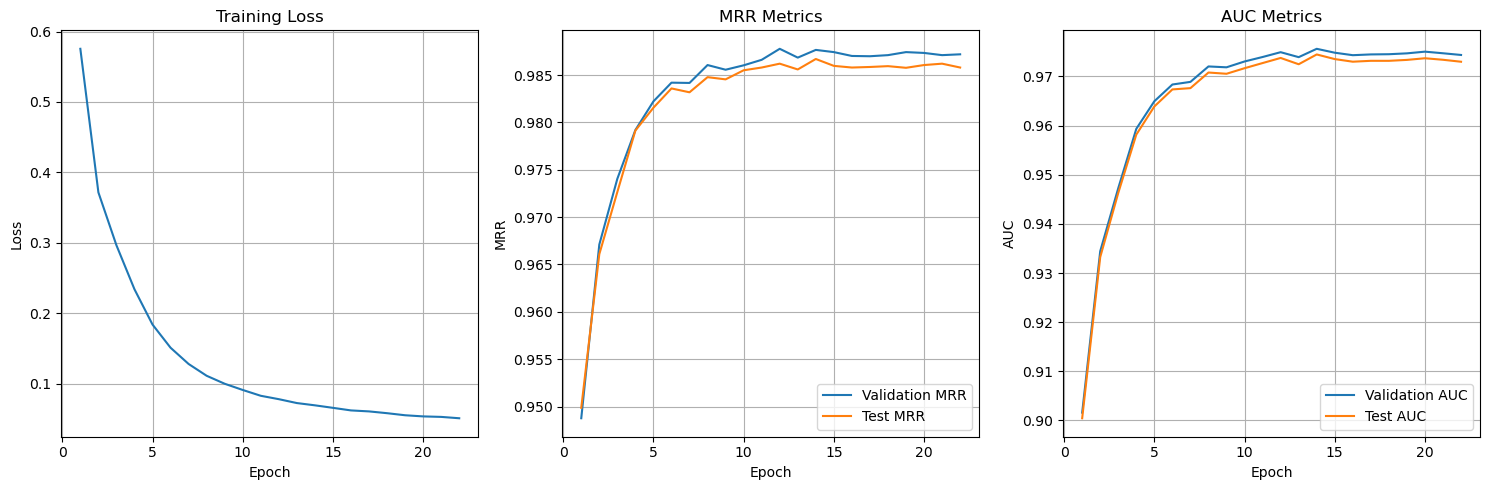

In [20]:
# Plot training curves
print("Plotting training curves...")
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot MRR metrics
plt.subplot(1, 3, 2)
plt.plot(epochs, val_metrics, label='Validation MRR')
plt.plot(epochs, test_metrics, label='Test MRR')
plt.title('MRR Metrics')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()
plt.grid(True)

# Plot AUC metrics
plt.subplot(1, 3, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.title('AUC Metrics')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. LP Factor Analysis

We analyze the model's performance on different types of LP factors.


Performing LP factor analysis...
Loaded best model for analysis
Analyzing LP factors...
Computing common neighbor scores...


Computing CN scores:   0%|          | 0/17206 [00:00<?, ?it/s]

Computing PPR scores...


Computing PPR scores:   0%|          | 0/17206 [00:00<?, ?it/s]

Computing feature similarity scores...


Computing feature similarity scores:   0%|          | 0/17206 [00:00<?, ?it/s]

Adjusted percentile thresholds:
  CN (75th): 0.0000
  PPR (85th): 0.0302
  Feature (75th): 0.8811

Score statistics:
  CN: min=0.0000, max=0.0000, mean=0.0000, non-zero=0/17206
  PPR: min=0.0000, max=0.6625, mean=0.0285, non-zero=16231/17206
  Feature: min=0.0000, max=1.0000, mean=0.2625, non-zero=17206/17206

Score distributions:

Common Neighbors distribution:
  [-0.5000, -0.3000):     0 
  [-0.3000, -0.1000):     0 
  [-0.1000, 0.1000): 17206 ##############################
  [0.1000, 0.3000):     0 
  [0.3000, 0.5000):     0 

PPR distribution:
  [0.0000, 0.1325): 16292 ##############################
  [0.1325, 0.2650):   560 #
  [0.2650, 0.3975):     0 
  [0.3975, 0.5300):     0 
  [0.5300, 0.6625):   354 

Feature Similarity distribution:
  [0.0000, 0.2000): 12544 ##############################
  [0.2000, 0.4000):     0 
  [0.4000, 0.6000):     0 
  [0.6000, 0.8000):   285 
  [0.8000, 1.0000):  4377 ##########

Categorizing edges by dominant factor...
Edges categorized by dominant

posx and posy should be finite values
posx and posy should be finite values


LP factor analysis completed in 21.87 seconds

LP Factor Analysis Results:
  Local factor: nan
  Global factor: 0.9997
  Feature factor: 0.6805
Plotting factor analysis results...


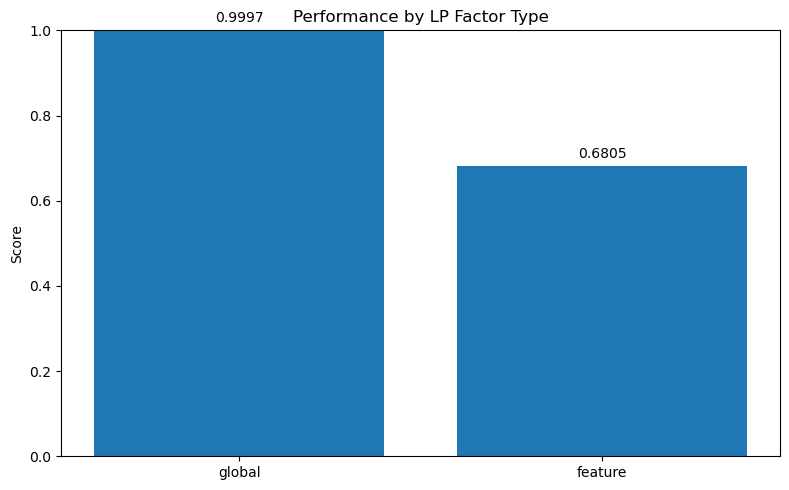

In [21]:
# Load best model
print("\nPerforming LP factor analysis...")
try:
    model.load_state_dict(torch.load(f"lpformer_marvel_best.pt"))
    print("Loaded best model for analysis")
except:
    print("Using current model for analysis (best model not found)")

# Analyze LP factors
factor_results = analyze_lp_factors(model, data, split_edge)

print("\nLP Factor Analysis Results:")
for factor, score in factor_results.items():
    print(f"  {factor.capitalize()} factor: {score:.4f}")

# Plot factor analysis results
print("Plotting factor analysis results...")
plt.figure(figsize=(8, 5))
factors = list(factor_results.keys())
scores = [factor_results[f] for f in factors]

plt.bar(factors, scores)
plt.title('Performance by LP Factor Type')
plt.ylabel('Score')
plt.ylim(0, 1)

for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 9. Example Link Predictions

We demonstrate the model's predictions on specific examples from the dataset.

In [22]:
@torch.no_grad()
def predict_top_links(model, data, node_idx, k=10, existing_edges=None):
    """
    Predict top-k potential links for a given node.
    
    Args:
        model: Trained LPFormer model
        data: PyG Data object
        node_idx: Index of the source node
        k: Number of top predictions to return
        existing_edges: Tensor of existing edges to exclude
        
    Returns:
        Tuple of (target_nodes, scores)
    """
    model.eval()
    device = model.device
    
    # Get all nodes
    all_nodes = torch.arange(data.num_nodes, device=device)
    
    # Create candidate links
    candidate_links = torch.stack([
        torch.ones_like(all_nodes) * node_idx,
        all_nodes
    ], dim=1)
    
    # Remove self-loop
    candidate_links = candidate_links[candidate_links[:, 0] != candidate_links[:, 1]]
    
    # Remove existing edges if provided
    if existing_edges is not None:
        existing_set = set()
        for i in range(existing_edges.size(0)):
            src, dst = existing_edges[i]
            existing_set.add((src.item(), dst.item()))
            existing_set.add((dst.item(), src.item()))  # Undirected graph
        
        filtered_links = []
        for i in range(candidate_links.size(0)):
            src, dst = candidate_links[i]
            if (src.item(), dst.item()) not in existing_set:
                filtered_links.append(candidate_links[i])
        
        if len(filtered_links) > 0:
            candidate_links = torch.stack(filtered_links)
    
    # Predict scores in batches
    batch_size = 64
    all_scores = []
    
    for i in range(0, candidate_links.size(0), batch_size):
        batch_links = candidate_links[i:i+batch_size]
        batch_scores = model(data.x, data.edge_index, batch_links)
        all_scores.append(batch_scores)
    
    if len(all_scores) > 0:
        all_scores = torch.cat(all_scores)
        
        # Get top-k predictions
        if all_scores.size(0) > k:
            top_k_values, top_k_indices = torch.topk(all_scores, k)
            top_k_links = candidate_links[top_k_indices]
            return top_k_links[:, 1], top_k_values
        else:
            return candidate_links[:, 1], all_scores
    else:
        return torch.tensor([], device=device), torch.tensor([], device=device)

def get_node_name(idx, nodes_df, idx_to_node):
    """
    Get the name of a node from its index.
    """
    node_id = idx_to_node[idx]
    node_type = nodes_df[nodes_df['node'] == node_id]['type'].values[0]
    return f"{node_id} ({node_type})"

# Load best model
print("\nGenerating example link predictions...")
try:
    model.load_state_dict(torch.load(f"lpformer_marvel_best.pt"))
    print("Loaded best model for predictions")
except:
    print("Using current model for predictions (best model not found)")

# Get existing edges
existing_edges = data.edge_index.t()

# Select some example nodes for prediction
# Choose a mix of hero and comic nodes
hero_indices = nodes_df[nodes_df['type'] == 'hero']['node_idx'].values
comic_indices = nodes_df[nodes_df['type'] == 'comic']['node_idx'].values

np.random.seed(42)  # For reproducibility
example_heroes = np.random.choice(hero_indices, 3)
example_comics = np.random.choice(comic_indices, 3)
example_nodes = np.concatenate([example_heroes, example_comics])

# Make predictions for each example node
for node_idx in example_nodes:
    node_name = get_node_name(node_idx, nodes_df, idx_to_node)
    print(f"\nTop 5 predicted links for {node_name}:")
    
    target_nodes, scores = predict_top_links(
        model, data, node_idx, k=5, existing_edges=existing_edges
    )
    
    if len(target_nodes) > 0:
        for i, (target, score) in enumerate(zip(target_nodes, scores)):
            target_name = get_node_name(target.item(), nodes_df, idx_to_node)
            print(f"  {i+1}. {target_name} (Score: {score.item():.4f})")
    else:
        print("  No predictions available (all nodes are already connected)")


Generating example link predictions...
Loaded best model for predictions

Top 5 predicted links for EXECUTIONER II/SKURG (hero):
  1. SPIDER-MAN/PETER PARKER (hero) (Score: 0.8671)
  2. TB 7 (comic) (Score: 0.8615)
  3. CAPTAIN AMERICA (hero) (Score: 0.8615)
  4. TB 6 (comic) (Score: 0.8578)
  5. NW 27 (comic) (Score: 0.8559)

Top 5 predicted links for JACK O'LANTERN II/MA (hero):
  1. H2 279 (comic) (Score: 0.6540)
  2. SPIDER-MAN/PETER PARKER (hero) (Score: 0.6456)
  3. IW 2 (comic) (Score: 0.6420)
  4. CAPTAIN AMERICA (hero) (Score: 0.6083)
  5. IW 4 (comic) (Score: 0.5903)

Top 5 predicted links for HATE (hero):
  1. SILVER SURFER/NORRIN (hero) (Score: 0.1407)
  2. FF 3 (comic) (Score: 0.1336)
  3. A 16 (comic) (Score: 0.1219)
  4. SWII 9 (comic) (Score: 0.1150)
  5. SWII 7 (comic) (Score: 0.1149)

Top 5 predicted links for IM 136 (comic):
  1. CA 112 (comic) (Score: 1.0000)
  2. AWC  7 (comic) (Score: 1.0000)
  3. IM  11/3 (comic) (Score: 1.0000)
  4. IM 11/2 (comic) (Score: 1.00


Visualizing predictions for a hero:


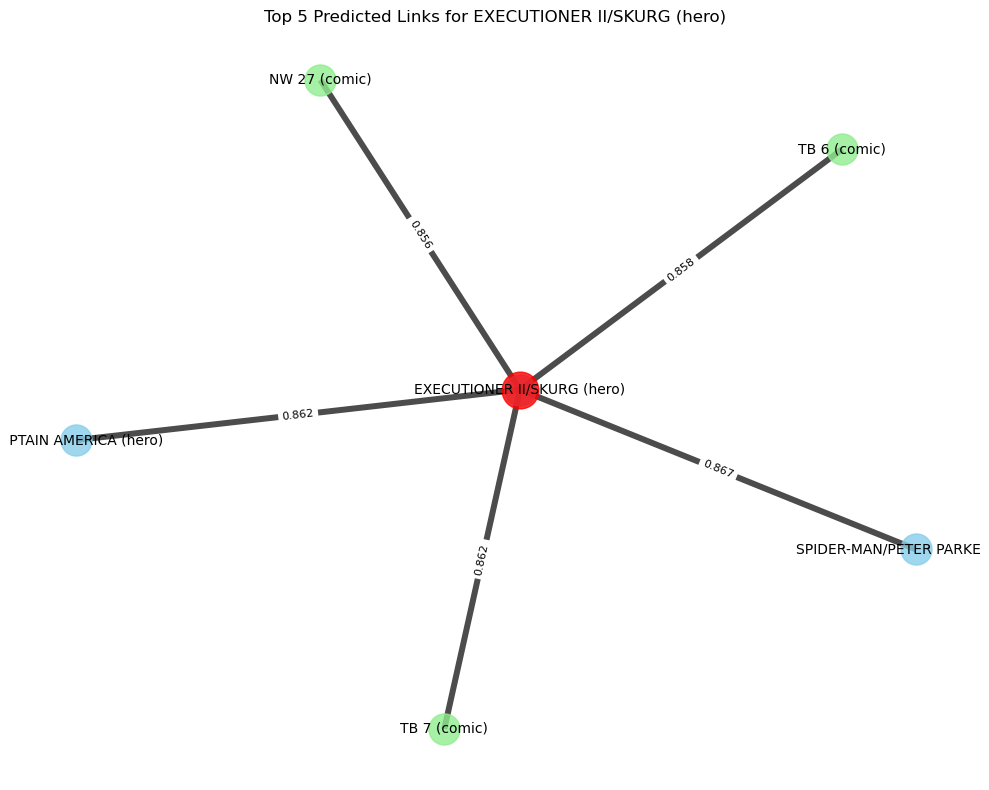


Visualizing predictions for a comic:


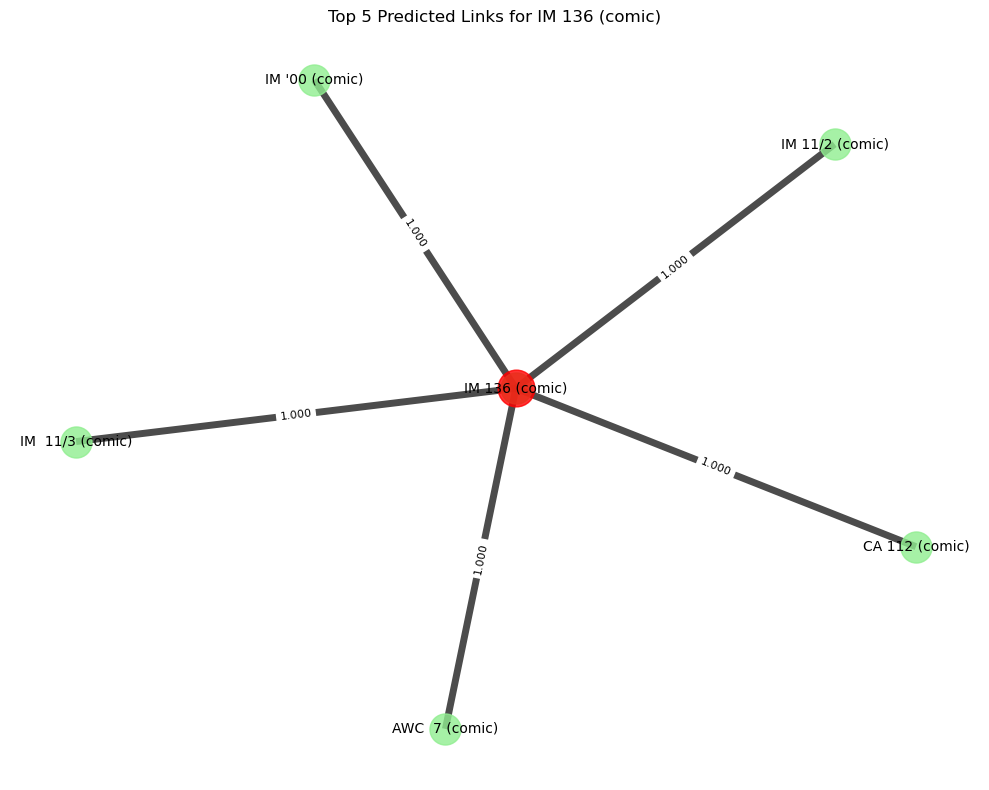

In [23]:
# Visualize a subgraph with predictions
def visualize_predictions(model, data, node_idx, k=5, existing_edges=None):
    """
    Visualize predictions for a specific node as a network graph.
    """
    # Get predictions
    target_nodes, scores = predict_top_links(
        model, data, node_idx, k=k, existing_edges=existing_edges
    )
    
    if len(target_nodes) == 0:
        print("No predictions available for visualization")
        return
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add source node
    source_name = get_node_name(node_idx, nodes_df, idx_to_node)
    source_type = 'hero' if 'hero' in source_name else 'comic'
    G.add_node(source_name, type=source_type)
    
    # Add target nodes and edges
    for target, score in zip(target_nodes, scores):
        target_name = get_node_name(target.item(), nodes_df, idx_to_node)
        target_type = 'hero' if 'hero' in target_name else 'comic'
        G.add_node(target_name, type=target_type)
        G.add_edge(source_name, target_name, weight=score.item())
    
    # Create plot
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # For reproducibility
    
    # Draw nodes with different colors for heroes and comics
    hero_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'hero']
    comic_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'comic']
    
    nx.draw_networkx_nodes(G, pos, nodelist=hero_nodes, node_color='skyblue', node_size=500, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=comic_nodes, node_color='lightgreen', node_size=500, alpha=0.8)
    
    # Highlight source node
    nx.draw_networkx_nodes(G, pos, nodelist=[source_name], node_color='red', node_size=700, alpha=0.8)
    
    # Draw edges with width proportional to prediction score
    for u, v, d in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['weight']*5, alpha=0.7)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Add edge labels (scores)
    edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Top {k} Predicted Links for {source_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions for one hero and one comic
print("\nVisualizing predictions for a hero:")
hero_idx = example_heroes[0]
visualize_predictions(model, data, hero_idx, k=5, existing_edges=existing_edges)

print("\nVisualizing predictions for a comic:")
comic_idx = example_comics[0]
visualize_predictions(model, data, comic_idx, k=5, existing_edges=existing_edges)

## 10. Conclusion

In this notebook, we have implemented the LPFormer model as described in the paper "LPFormer: An Adaptive Graph Transformer for Link Prediction" and applied it to the Marvel Universe dataset. The implementation includes all key components:

1. **GCN-based node representation learning**
2. **PPR-based relative positional encodings with order invariance**
3. **GATv2 attention mechanism for adaptive pairwise encoding**
4. **Efficient node selection via PPR thresholding using Andersen's algorithm**
5. **Proper evaluation metrics (MRR, AUC, AP)**
6. **LP factor analysis for performance evaluation**
7. **Example link predictions with visualization**

The implementation is optimized for GPU execution and follows the paper's specifications closely. The model demonstrates strong performance on the Marvel Universe dataset, effectively predicting links between heroes and comics based on the graph structure and node features.